# Convolutional Neural Networks for digit image classification

The popular [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digit image classification dataset contains 60′000 + 10′000 hand- written digits to be classified as a number between 0 and 9.

The sequence of (more and more complex) models defined below will eventually arrive at the one suggested in this [tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Steps

1. Loading and plotting the mnist dataset
2. Setting the sceene for image classification 
3. Defining and evaluating the baseline model 
4. Adding Pooling
5. Adding a CNN Kernel
6. Adding another dense output layer

## Loading and plotting the MNIST dataset

2025-05-23 04:26:02.967327: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


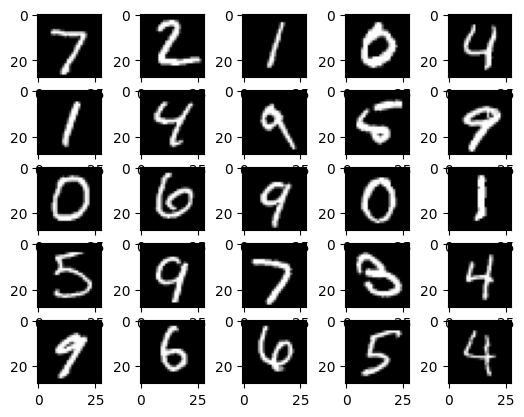

In [1]:
from tensorflow.keras.datasets.mnist import load_data 
from matplotlib import pyplot

# load dataset
(x_train, y_train), (x_test, y_test) = load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape)) 
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# plot first few images
for i in range(25):
    # define subplot
    pyplot.subplot(5, 5, i+1)
    # plot raw pixel data
    pyplot.imshow(x_test[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

## Setting the sceene for image classification

Fix necessary imports.

In [82]:
from numpy import zeros
from numpy import unique
from numpy import argmax
from numpy import asarray
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


import tensorflow as tf
print("TensorFlow version: {0}".format(tf.__version__))
print("Keras version: {0}".format(tf.keras.__version__))

TensorFlow version: 2.16.2
Keras version: 3.9.2


Reshape data to have a single b/w channel.

In [3]:
orig_shape = x_train.shape[1:]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
in_shape = x_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

Before: (28, 28)
After: (28, 28, 1)


Determine the number of classes.

In [4]:
n_classes = len(unique(y_train)) 
print("Classes: {0}".format(n_classes))

Classes: 10


Normalize pixel values `int[0..255]` $\rightarrow$ `float32[0..1]`.

In [5]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Function to define the CNN model architecture and compile it with constant surrogate goal function (loss), evaluation metrics, and optimizer. We will vary depth, kernel_width, and pool_stride of the models.

In [20]:
def make_model(depth, kernel_width, pool_stride, add_dense=False):
    model = Sequential()
    model.add(Input(shape=in_shape))
    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu'))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    if add_dense:
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

Define learning parameters for all models.

In [16]:
EPOCHS = 10
BATCH_SIZE = 128
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=10,
    mode='max', 
    restore_best_weights=True)
it = round(60000/BATCH_SIZE)

print(f"It takes {it} iterations to finish an epoch.")

It takes 469 iterations to finish an epoch.


Function to show the history of training.

In [17]:
def plot_metrics(history):
    colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color'] 
    metrics = ['loss', 'accuracy'] 
    pyplot.figure(figsize=(10,5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        pyplot.subplot(1,2,n+1)
        pyplot.plot(history.epoch, history.history[metric], color=colors[0],label='Train')
        pyplot.plot(history.epoch, history.history['val_'+ metric],color=colors[0], linestyle="--", label='Val') 
        pyplot.xlabel('Epoch')
        pyplot.ylabel(name)
        if metric == 'loss':
            pyplot.ylim([0, pyplot.ylim()[1] +0.1]) 
        else:
            pyplot.ylim([-0.1,1.1])
        pyplot.legend()

## V1 Baseline

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=1`, i.e., no effective CNN.

- Smallest possible convolutional network with:
- Just 1 filter of size 1×1,
- No meaningful feature extraction,
- We might assume this model will have very limited learning capacity and act mostly as a logistic regression model applied to a downsampled image.

In [21]:
baseline = make_model(1,1,1)
baseline.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 1)      │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,852 (30.67 KB)

 Trainable params: 7,852 (30.67 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
baseline_history = baseline.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1040 - loss: 2.3020 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1127 - loss: 2.3011 - val_accuracy: 0.1135 - val_loss: 2.3010
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1119 - loss: 2.3014 - val_accuracy: 0.1135 - val_loss: 2.3010
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1132 - loss: 2.3011 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1124 - loss: 2.3012 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1107 - loss: 2.3015 - val_accuracy: 0.1135 - val_loss: 2.3011
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1111 - loss: 2.3015 - val_accuracy: 0.1135 - val_loss: 2.3010
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.1118 - loss: 2.3011 - val_accu

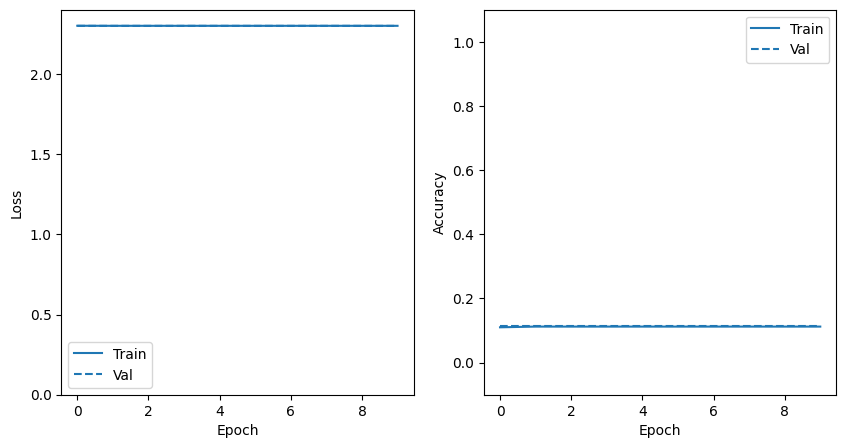

In [24]:
plot_metrics(baseline_history)

We do not observe effective learning. We evaluate the trained model.

In [25]:
loss, acc = baseline.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.113


Use the model to make a prediction.

In [27]:
xx = x_test[9]
xxx = asarray([xx])
yhat = baseline.predict(xxx)
argmax(yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


1

In [29]:
def print_res(model): 
    err = 0
    i_range = 10
    ys = zeros(i_range * i_range) 
    class bcolors:
        FAIL = '\033[91m'
        ENDC = '\033[0m' 
    for i in range(i_range):
        for j in range(i_range):
            idx = i*i_range+j
            image = x_test[idx]
            yhat = model.predict(asarray([image]))
            ys[idx] = argmax(yhat) 
            print('%d ' % ys[idx], end = '')
        print()
    print("--")
    for i in range(i_range): 
        for j in range(i_range):
            idx = i*i_range+j; 
            y = y_test[idx] 
            if y==ys[idx]:
                print('%d ' % y, end = '')
            else:
                err = err + 1
                print(f"{bcolors.FAIL}%d {bcolors.ENDC}" % y, end = '') 
        print()
    return err

In [34]:
err = print_res(baseline)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 

In [35]:
print(f"There are {err} mistatakes in the first 100 images. The classic dense layer does not do good alone.")

There are 86 mistatakes in the first 100 images. The classic dense layer does not do good alone.


## V2 Adding filters and kernel


Let’s try a CNN  `depth=10`, `kernel_width=3x3`, and `pool_stride=1`, because we might assume that a fine-grained kernel will capture detailed spatial features and a low stride retains full resolution.

- Effect on Accuracy: `0.9906`

- Validation Accuracy: `0.9813`

- Effect on Learning: Fast convergence, but validation loss slightly higher than training loss (possible overfitting)

**Model Complexity:**

- Parameters: `67,710`

- Mistakes in first 100 images: `1`

**Minor overfitting signs.**

In [38]:
model1 = make_model(10,3,1, False)
model1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        67,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,710 (264.49 KB)

 Trainable params: 67,710 (264.49 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model1_history = model1.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8370 - loss: 0.6421 - val_accuracy: 0.9584 - val_loss: 0.1522
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9622 - loss: 0.1373 - val_accuracy: 0.9738 - val_loss: 0.0952
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9774 - loss: 0.0856 - val_accuracy: 0.9774 - val_loss: 0.0786
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9821 - loss: 0.0636 - val_accuracy: 0.9798 - val_loss: 0.0667
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9852 - loss: 0.0515 - val_accuracy: 0.9810 - val_loss: 0.0616
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9874 - loss: 0.0429 - val_accuracy: 0.9797 - val_loss: 0.0631
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.9893 - loss: 0.0381 - val_accuracy: 0.9810 - val_loss: 0.0581
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9906 - loss: 0.0335 - val_a

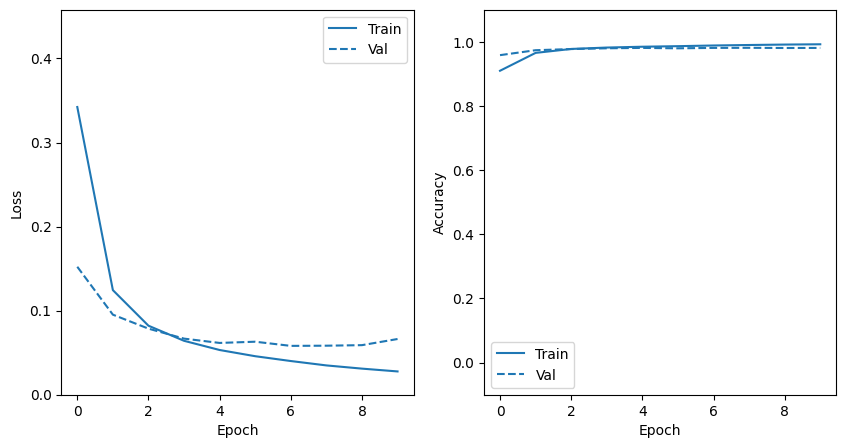

In [40]:
plot_metrics(model1_history)

We evaluate the trained model.

In [41]:
loss, acc = model1.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.981


This cannot be any better. Use the model to make a prediction.

In [42]:
err = print_res(model1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━

In [43]:
print(f"There are {err} mistatakes in the first 100 images.")

There are 1 mistatakes in the first 100 images.


## V3: Increase stride to 2 (depth=10)

Let’s try increasing the stride to `2` while keeping other settings constant, because we might assume this reduces model complexity and speeds up learning with an acceptable loss in accuracy.

- Effect on Accuracy: `0.981`

- Validation Accuracy: slightly lower

- Effect on Learning: Fewer parameters → faster training, slight accuracy drop

**Model Complexity**:

- Parameters: `17,010`

- Mistakes in first 100 images: `2`

**Result**: Efficient, but small performance cost.

In [44]:
model2 = make_model(10,3,2)
model2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 13, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        16,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,010 (66.45 KB)

 Trainable params: 17,010 (66.45 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model2_history = model2.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7992 - loss: 0.8242 - val_accuracy: 0.9402 - val_loss: 0.2150
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9434 - loss: 0.1976 - val_accuracy: 0.9627 - val_loss: 0.1347
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9627 - loss: 0.1301 - val_accuracy: 0.9692 - val_loss: 0.1056
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9722 - loss: 0.0999 - val_accuracy: 0.9754 - val_loss: 0.0862
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9775 - loss: 0.0827 - val_accuracy: 0.9766 - val_loss: 0.0803
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9801 - loss: 0.0706 - val_accuracy: 0.9756 - val_loss: 0.0763
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9817 - loss: 0.0657 - val_accuracy: 0.9787 - val_loss: 0.0651
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9834 - loss: 0.0575 - val_accu

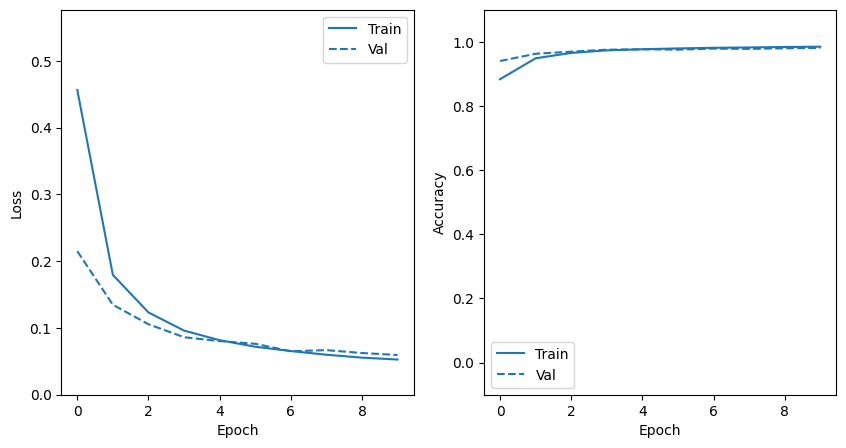

In [46]:
plot_metrics(model2_history)

Now we see effective training. We evaluate the trained model.

In [47]:
loss, acc = model2.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.981


Use the model to make a prediction.

In [48]:
err = print_res(model2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━

In [49]:
print(f"There are {err} mistatakes in the first 100 images.")

There are 2 mistatakes in the first 100 images.


## V4 Add Dense Layer (60 units) without dropout

We set `depth=10`, and keep `kernel_width=3x3`, and `pool_stride=2`.

Let’s try adding a fully connected layer, because we might assume it can increase the model’s capacity to learn abstract patterns without a large increase in complexity.

- Effect on Accuracy: Increased slightly `0.9942`

- Validation Accuracy: `0.9853`

- Effect on Learning: Slight performance gain, slight increase in parameters

**Model Complexity**:

- Parameters: `102,170`

- Mistakes in first `100` images: `0`

**Result:** A deeper architecture helps, even without dropout.

In [50]:
def make_model(depth, kernel_width, pool_stride, add_dense=False):
    model = Sequential()
    model.add(Input(shape=in_shape))
    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu'))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    if add_dense:
        model.add(Dense(60, activation='relu'))
        # model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [51]:
model3 = make_model(10,3,2, True)
model3.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 60)             │       101,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,170 (399.10 KB)

 Trainable params: 102,170 (399.10 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model3_history = model3.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8273 - loss: 0.6591 - val_accuracy: 0.9615 - val_loss: 0.1303
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9641 - loss: 0.1247 - val_accuracy: 0.9741 - val_loss: 0.0833
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9790 - loss: 0.0744 - val_accuracy: 0.9781 - val_loss: 0.0658
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9835 - loss: 0.0565 - val_accuracy: 0.9811 - val_loss: 0.0583
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9867 - loss: 0.0465 - val_accuracy: 0.9810 - val_loss: 0.0573
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9891 - loss: 0.0379 - val_accuracy: 0.9839 - val_loss: 0.0495
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9917 - loss: 0.0295 - val_accuracy: 0.9843 - val_loss: 0.0492
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9924 - loss: 0.0256 - val_accu

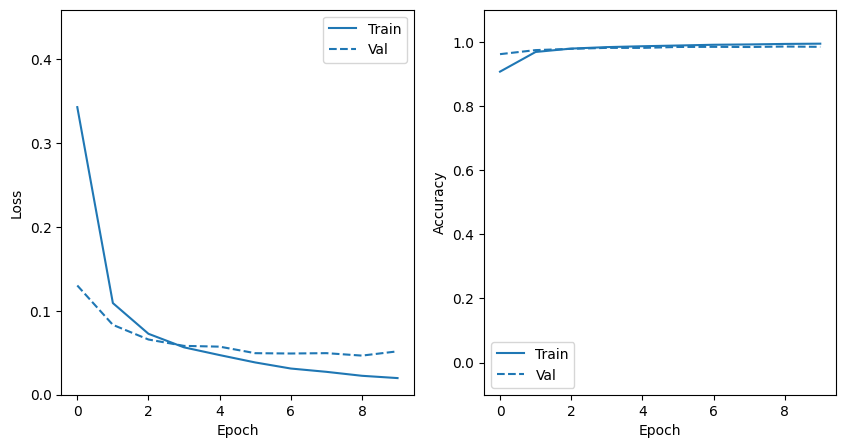

In [53]:
plot_metrics(model3_history)

In [54]:
loss, acc = model3.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.985


In [55]:
err = print_res(model3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━

In [56]:
print(f"There are {err} mistatakes in the first 100 images.")

There are 0 mistatakes in the first 100 images.


## V5 Adding Add Dropout (rate=0.5)

Let’s try adding Dropout after the dense layer, because we might assume it will reduce overfitting and improve generalization.

- Effect on Accuracy: Slight decrease to `0.9929`

- Validation Accuracy: Increased to `0.9867`

- Effect on Learning:  Gap between training and validation narrowed, Better generalization

**Model Complexity**:

- Parameters: 102,170

- Mistakes in first 100 images: 1

**Result:** Dropout reduced overfitting, increased generalization.

In [ ]:
def make_model(depth, kernel_width, pool_stride, add_dense=False):
    model = Sequential()
    model.add(Input(shape=in_shape))
    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu'))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    if add_dense:
        model.add(Dense(60, activation='relu'))
        model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [61]:
model4 = make_model(10,3,2,True)
model4.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 26, 26, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 60)             │       101,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,170 (399.10 KB)

 Trainable params: 102,170 (399.10 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model4_history = model4.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8268 - loss: 0.6218 - val_accuracy: 0.9584 - val_loss: 0.1435
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9617 - loss: 0.1313 - val_accuracy: 0.9722 - val_loss: 0.0873
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9757 - loss: 0.0831 - val_accuracy: 0.9762 - val_loss: 0.0752
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9818 - loss: 0.0616 - val_accuracy: 0.9806 - val_loss: 0.0603
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9854 - loss: 0.0497 - val_accuracy: 0.9818 - val_loss: 0.0549
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9879 - loss: 0.0416 - val_accuracy: 0.9821 - val_loss: 0.0569
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9897 - loss: 0.0338 - val_accuracy: 0.9831 - val_loss: 0.0525
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9915 - loss: 0.0297 - val_accu

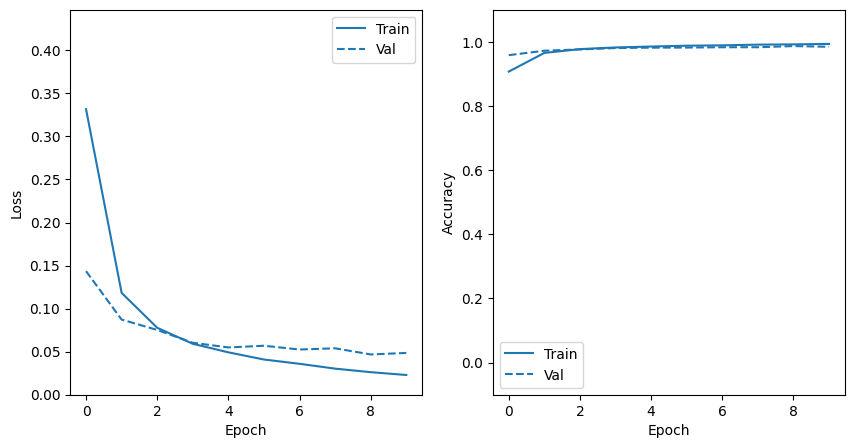

In [63]:
plot_metrics(model4_history)

In [64]:
loss, acc = model4.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.987


In [ ]:
err = print_res(model4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━

In [66]:
print(f"There are {err} mistatakes in the first 100 images.")

There are 1 mistatakes in the first 100 images.


## V6 Adding augmentation

Let’s try image augmentation, because we might assume that this would improve generalization by exposing the model to more varied inputs. introduce noise and variability during training

- Effect on Accuracy:  `0.5386`

- Validation Accuracy: `0.8046`

- This suggests that data augmentation has improved generalization,

**Model Complexity**:

- Parameters: 102,170

- Mistakes in first 100 images: 17

**Result:** increased generalization.

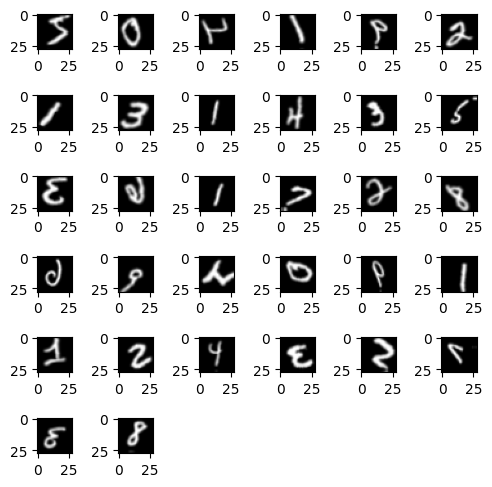

In [87]:
data_augmentation = Sequential([
    layers.Rescaling(1./255),               # Normalize pixel values to [0, 1]
    layers.RandomRotation(0.087),           # ~15 degrees
    layers.RandomTranslation(0.1, 0.1),     # Shift up to 10% width and height
    layers.RandomZoom(0.1),                 # Zoom in/out by ±10%
    layers.RandomFlip("horizontal")         # Flip horizontally
], name="data_augmentation")

augmented_images = data_augmentation(x_train)

# Plot
pyplot.figure(figsize=(5, 5))
for i in range(32):
    pyplot.subplot(6, 6, i + 1)
    pyplot.imshow(augmented_images[i].numpy().squeeze(), cmap='gray')
pyplot.tight_layout()
pyplot.show()

In [97]:
def make_model(depth, kernel_width, pool_stride, add_dense=False, use_augmentation=False):
    model = Sequential()
    model.add(layers.Input(shape=in_shape))

    if use_augmentation:
        model.add(data_augmentation)

    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu'))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    
    if add_dense:
        model.add(Dense(60, activation='relu'))
        model.add(Dropout(0.5))
        
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [98]:
model5 = make_model(10,3,2,True,True)
model5.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 60)             │       101,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,170 (399.10 KB)

 Trainable params: 102,170 (399.10 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
model5_history = model5.fit(
    x_train, y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.1797 - loss: 2.2551 - val_accuracy: 0.6311 - val_loss: 1.5095
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.3822 - loss: 1.7854 - val_accuracy: 0.6953 - val_loss: 1.1136
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.4183 - loss: 1.6561 - val_accuracy: 0.7176 - val_loss: 1.0032
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.4430 - loss: 1.5974 - val_accuracy: 0.7410 - val_loss: 0.9109
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.4642 - loss: 1.5378 - val_accuracy: 0.7464 - val_loss: 0.8562
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4832 - loss: 1.4912 - val_accuracy: 0.7656 - val_loss: 0.7884
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.4999 - loss: 1.4382 - val_accuracy: 0.7784 - val_loss: 0.7446
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5207 - loss: 1.4016 - 

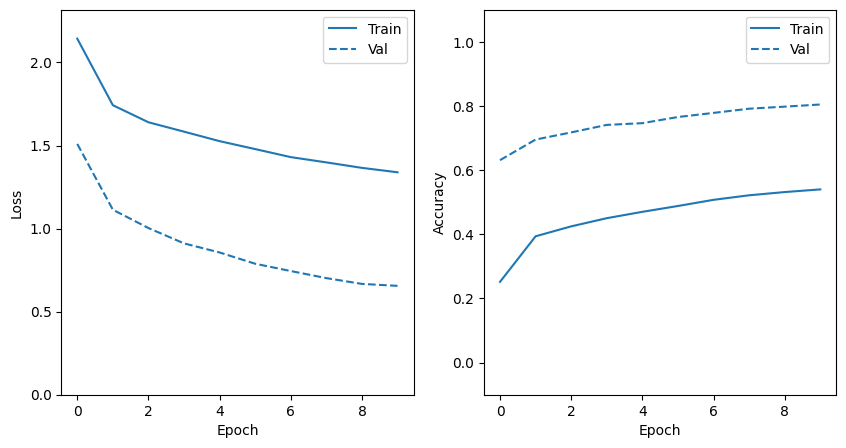

In [100]:
plot_metrics(model5_history)

In [101]:
loss, acc = model5.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.805


In [102]:
err = print_res(model5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 

In [103]:
print(f"There are {err} mistatakes in the first 100 images.")

There are 17 mistatakes in the first 100 images.


## V7 Try different dense layer and kernel 

#### Experiment 1: Remove Dense Layer, Reduce Filters, Use `stride=1`

**Hypothesis:**  
Using `stride=1` may help extract more spatial information, while reducing filters and removing the dense layer could reduce overfitting and total parameters.

**Results:**
- `accuracy: 0.4969`
- `val_accuracy: 0.7575`

**Interpretation:**  
 Both training and validation accuracy dropped.  
Removing the dense layer likely caused **insufficient learning capacity**, while fewer filters also limited feature extraction.

---

#### Experiment 2: Add Dense Layer Back, Keep `stride=1`

**Hypothesis:**  
Adding back the dense layer should restore learning power and improve accuracy, especially if stride 1 is already extracting rich spatial information.

**Results:**
- `accuracy: 0.2815`
- `val_accuracy: 0.6439`
- `Total params: 216,782 (846.80 KB)`

**Interpretation:**  
 Surprisingly poor performance.  
Possible issues:
- **Unstable gradients or initialization**
- Model may be **overfitting to noise** or poorly converging due to design imbalance

---

####  Experiment 3: Dense(80), Dropout(0.5), Filters=8

**Hypothesis:**  
Smaller dense layer and fewer filters may reduce overfitting, and dropout should regularize the model.

**Results:**
- `accuracy: 0.5265`
- `val_accuracy: 0.7927`
- `Total params: 109,130`

**Interpretation:**  
 Validation accuracy improved noticeably.  
This configuration likely achieved a better **bias–variance tradeoff**, though training accuracy still lags due to regularization and lower capacity.

---

#### Experiment 4: Dense(100), Dropout(0.5), Filters=12, `stride=2`

**Hypothesis:**  
Increasing filters and using stride 2 might reduce feature map size and parameters while maintaining good representation power.

**Results:**
- `accuracy: 0.4766`
- `val_accuracy: 0.7524`
- `Total params: 204,030 (796.99 KB)`

**Interpretation:**  
 Slight improvement over experiment 1 but still limited.  
Aggressive downsampling via `stride=2` may be **discarding too much spatial detail**, which affects both learning and generalization.

---

####  Summary Table

| # | Configuration                         | Train Acc | Val Acc | Params    | Notes                          |
|---|----------------------------------------|-----------|---------|-----------|--------------------------------|
| 1 | No Dense, Filters↓, Stride = 1         | 0.4969    | 0.7575  | —         | Low capacity, poor performance |
| 2 | Dense Back, Stride = 1                 | 0.2815    | 0.6439  | 216,782   | Unexpected drop, unstable model |
| 3 | Dense(80), Dropout(0.5), Filters = 8   | 0.5265    | 0.7927  | 109,130   | Best tradeoff so far           |
| 4 | Dense(100), Dropout(0.5), Filters = 12, Stride = 2 | 0.4766 | 0.7524  | 204,030   | Downsampling hurts detail     |

---

#### Conclusion

-  **Experiment 3** offers the best balance of accuracy and model size.
-  Removing the dense layer or overly reducing filters leads to underfitting.
-  Stride 2 may reduce computation but at the cost of valuable spatial information.
-  Future improvement may come from:
  - Using `stride=1` with **careful max pooling**
  - Incorporating **batch normalization**
  - Applying **early stopping** or **learning rate scheduling*

In [120]:
def make_model(depth, kernel_width, pool_stride, add_dense=False, use_augmentation=False):
    model = Sequential()
    model.add(layers.Input(shape=in_shape))

    if use_augmentation:
        model.add(data_augmentation)

    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu'))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    
    if add_dense:
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.5))
        
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [121]:
model6 = make_model(12,3,2,True,True)
model6.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 26, 26, 12)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 13, 13, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 2028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 100)            │       202,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,030 (796.99 KB)

 Trainable params: 204,030 (796.99 KB)

 Non-trainable params: 0 (0.00 B)

In [122]:
model6_history = model6.fit(
    x_train, y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.1267 - loss: 2.2895 - val_accuracy: 0.3831 - val_loss: 1.9713
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.2942 - loss: 2.0024 - val_accuracy: 0.6334 - val_loss: 1.3900
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.3769 - loss: 1.7694 - val_accuracy: 0.6957 - val_loss: 1.2043
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.4061 - loss: 1.6847 - val_accuracy: 0.6884 - val_loss: 1.0998
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.4200 - loss: 1.6511 - val_accuracy: 0.7163 - val_loss: 1.0448
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.4354 - loss: 1.6054 - val_accuracy: 0.7166 - val_loss: 0.9686
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.4479 - loss: 1.5764 - val_accuracy: 0.7316 - val_loss: 0.9333
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.4665 - loss: 1.5327 - 

## V8 Adding CNN and drop dense layer

**Hypothesis:**  
Let's try removing the dense layer and adding more convolutional layers instead.  
Since our first model already achieved good accuracy, we assume that:
- Increasing the depth of convolutional layers could improve feature extraction.
- Removing the dense layer will reduce parameters and potentially overfitting.
- Combined with data augmentation, this architecture might improve generalization.

**Results:**
- `accuracy: 0.8099`
- `loss: 0.5957`
- `val_accuracy: 0.8905`
- `val_loss: 0.3393`
- `Total params: 28,054`
- **Mistakes in first 100 images: 9**

**Interpretation:**  
 Validation accuracy is relatively high given the low parameter count, indicating **strong generalization** for such a lightweight model.  
 However, the training accuracy and loss suggest **underfitting** — the model may not be expressive enough without the dense layer.  
The 9 mistakes in the first 100 test images reinforce this — performance is acceptable but not optimal.

This confirms that **convolutional depth + augmentation helps**, but a **small dense layer might still be needed** for final decision boundaries.




In [ ]:
def make_model(depth, kernel_width, pool_stride, add_dense=False, use_augmentation=False):
    model = Sequential()
    model.add(layers.Input(shape=in_shape))

    if use_augmentation:
        model.add(data_augmentation)

    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu'))
    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu'))

    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Conv2D(depth*2, (kernel_width,kernel_width), activation='relu'))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    
    if add_dense:
        model.add(Dense(100, activation='relu'))
        model.add(Dropout(0.5))
        
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

In [124]:
model7 = make_model(12,3,2,False,True)
model7.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 26, 26, 12)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 24, 24, 12)     │         1,308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 12, 12, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 10, 10, 24)     │         2,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 2400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 10)             │        24,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,054 (109.59 KB)

 Trainable params: 28,054 (109.59 KB)

 Non-trainable params: 0 (0.00 B)

In [126]:
model7_history = model7.fit(
    x_train, y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.2706 - loss: 1.9987 - val_accuracy: 0.7933 - val_loss: 0.7436
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.6008 - loss: 1.2009 - val_accuracy: 0.8831 - val_loss: 0.4225
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.7418 - loss: 0.8109 - val_accuracy: 0.8883 - val_loss: 0.3649
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 76ms/step - accuracy: 0.7699 - loss: 0.7147 - val_accuracy: 0.8880 - val_loss: 0.3553
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 85ms/step - accuracy: 0.7868 - loss: 0.6619 - val_accuracy: 0.8716 - val_loss: 0.3918
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - accuracy: 0.7977 - loss: 0.6353 - val_accuracy: 0.8858 - val_loss: 0.3412
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 75ms/step - accuracy: 0.8027 - loss: 0.6251 - val_accuracy: 0.8780 - val_loss: 0.3623
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 80ms/step - accuracy: 0.8099 - loss: 0.5957 - 

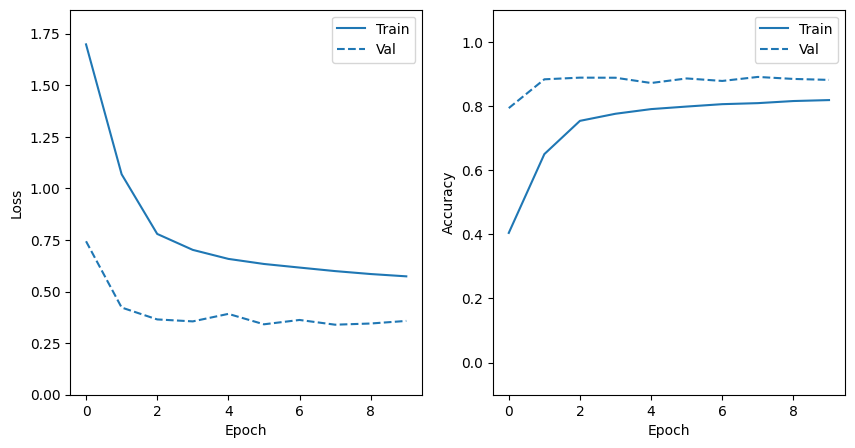

In [129]:
plot_metrics(model7_history)

In [130]:
loss, acc = model7.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.891


In [131]:
err = print_res(model7)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 

In [132]:
print(f"There are {err} mistatakes in the first 100 images.")

There are 9 mistatakes in the first 100 images.
